TODO:

- fix input token axis
- plot shared tokens
- plot shared PCA
- random macro analysis
- redo input length experiments

# Attention tokens

While exploring some other behaviour I noticed that different heads consistently produce tokens from a compacted subsets of the full vocabulary set when you project the components of a head onto the residual stream without going through the MLP layers. I think this is likely heavily influenced by positional encodings.

Each head appears to use it's learn vocabulary subset (the attention tokens) to chunk inputs in ways specific to that head. Some heads compress inputs into a small number attention tokens - as few as 3-4 for 16 token inputs. Others expand and others linearly track or double with input. My intuition is that this represents how heads structurally decompose inputs to represent meaning for their specific tasks and so provides a means for classifying heads.

Macro patterns across heads also emerge - particularly when considering the element-wise product of q and k. The plots below show the t-SNE for the embeddings of the element-wise tokens with colors representing layers and the shared element-wise tokens between heads.

<div style="display: flex; justify-content: center;">
    <img src="./imdb-tsne.png" alt="Image 1" style="width: 45%; margin-right: 10px;">
    <img src="./shared-token_imdb.png" alt="Image 2" style="width: 45%;">
</div>

In [1]:
import torch
from transformer_lens import HookedTransformer 
import plotly.io as pio
import matplotlib.pyplot as plt

from utils import *

torch.cuda.empty_cache()
torch.set_grad_enabled(False)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
pio.renderers.default = "png"
plt.ioff()

The plot below allows you to explore how attention tokens are generated. Note, the colourscale is based on the order in which the attention tokens are discovered during generation meaning brighter colours represent tokens generated later in the process. This means that colours don't represent absolute token values and instead more of a relative position within the generation.

In [3]:
prompt = "The next sentence is false. The previous sentence is true."
cache = run_prompts(model, prompt)

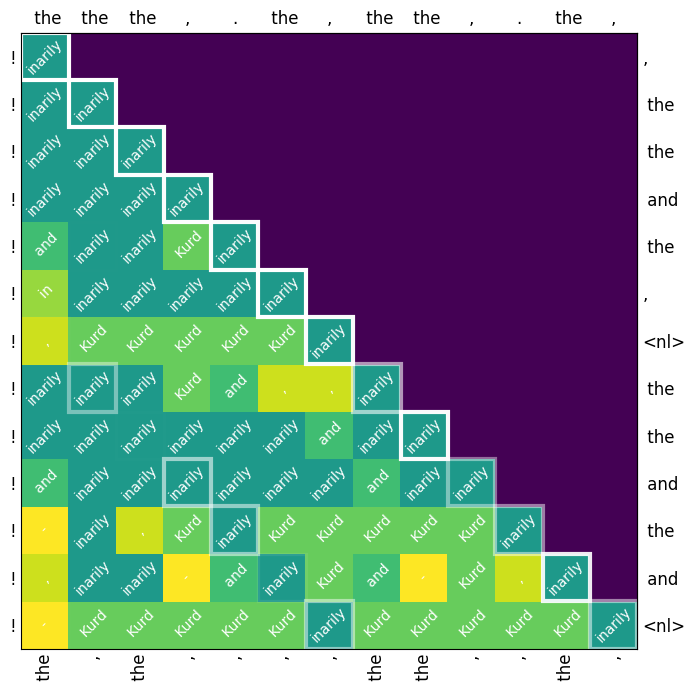

In [4]:
l, h = 0, 1
attn_data = calculate_attns(cache, l, h)
plot = plot_attn(model, attn_data)

figure(
    plot, 
    title=f"Attention tokens for {l}.{h}", 
    description="""
    Each cell represents the element-wise product of the Q and K components of the attention head. Colors increase in brightness based on the order in which the attention tokens were discovered in the raw input.
    Axis clockwise from top: query, key, value, and input tokens.
    Attention scores for the final position are overlaid as white borders.
    """,
    footer=f'Input: {prompt}',
)

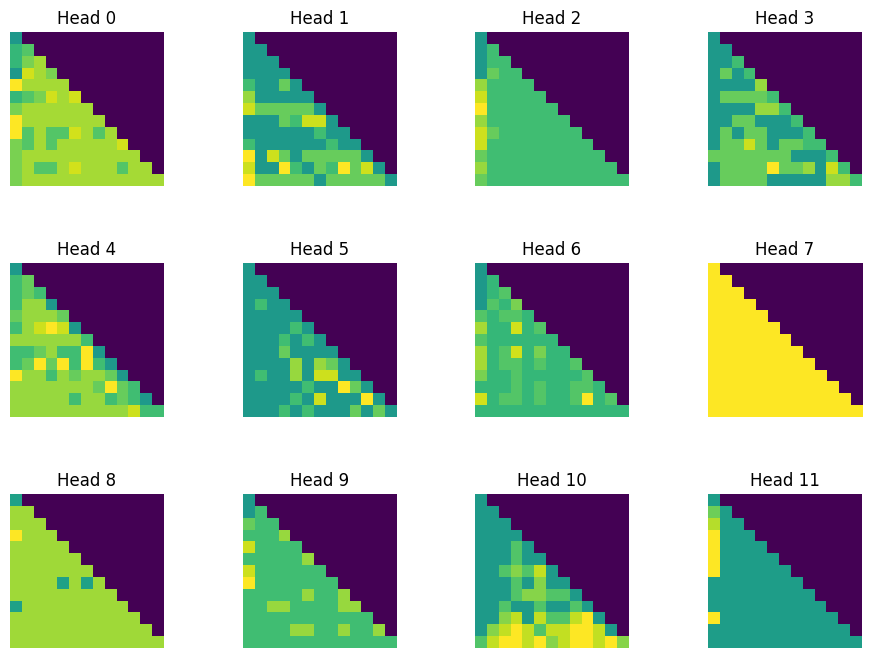

In [5]:
plot, axs = plt.subplots(3, 4, figsize=(12, 8))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, l, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(
    plot, 
    title=f"Attention token plots for each head in layer {l}",
    description="""
    Note that the colors are relative and don't represent the same atttention token across heads. 
    Instead the patterns show how each head uses the tokens within its vocabulary set.
    """,
    footer=f'Input: {prompt}',
)

To get a sense of how attention tokens are generated I want to test over a reasonably large and varied inputs. For the time being I'm using the imdb dataset because it contains a wide variety of natural language from multiple authors and is relatively small.

The code below extracts 3 random prompts from the dataset and uses them as the input into the model. We then use the cached activations to generate a dataset of attention tokens for each component across each head. The length of each prompt is capped at 16 tokens.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb")
inputs = random.choices(dataset["train"]["text"], k=3)
inputs = model.to_string(model.to_tokens(inputs)[:, :16])
cache = run_prompts(model, *inputs)

data = generate(cache)
df = to_df(data)
df.to_csv("imdb_example.csv", index=False)
df

Generating the attention token dataset from activations can take a while depending on how many inputs you have and how long they are. To save time, I've pre-generated a dataset of 32 prompts with a token length of 32 from the imdb dataset.

In [6]:
df = load('../data/32x32_attn.csv')
df

,layer,head,Input token,attn,hp,q,k,v
0,0.0,0.0,50256.0,1.000000,357.0,11.0,11.0,262.0
1,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
2509051,11.0,11.0,379.0,0.002832,47992.0,10473.0,47992.0,2887.0
2509052,11.0,11.0,379.0,0.002169,47992.0,10473.0,47992.0,2887.0
2509053,11.0,11.0,379.0,0.004394,47992.0,10473.0,47992.0,2887.0
2509054,11.0,11.0,379.0,0.016218,23712.0,10473.0,47992.0,2887.0


While it's interesting to look at the patterns that emerge in the token plots, and I think it can be useful for interpreting head behaviour (see below), it doesn't help to understand any macro patterns that may exist across the model heads.

Calculating fequencies of each token shows a dramatic compaction down to ~1200 tokens for the element-wise product and ~10000 for the Q and K components and ~25000 for V. These numbers seem relatively invariant to actual token input and length - see random token experiments below for more details.

In [7]:
token_counts = token_freq_data(model, df, 4, (144, 32, 32, 32))
q_token_counts = token_freq_data(model, df, 5, (144, 32, 32, 32))
k_token_counts = token_freq_data(model, df, 6, (144, 32, 32, 32))
v_token_counts = token_freq_data(model, df, 7, (144, 32, 32, 32))
token_counts

,Head,Token,Frequency,Token str,Rank
0,0,11,1325,",",4.0
1,0,12,461,-,6.0
2,0,198,82,\n,12.0
3,0,287,94,in,11.0
4,0,290,328,and,7.0
...,...,...,...,...,...
1207,76,9228,223,burgh,5.0
1208,76,22150,292,ultz,4.0
1209,76,23712,3923,eday,2.0
1210,76,30044,407,Jude,3.0


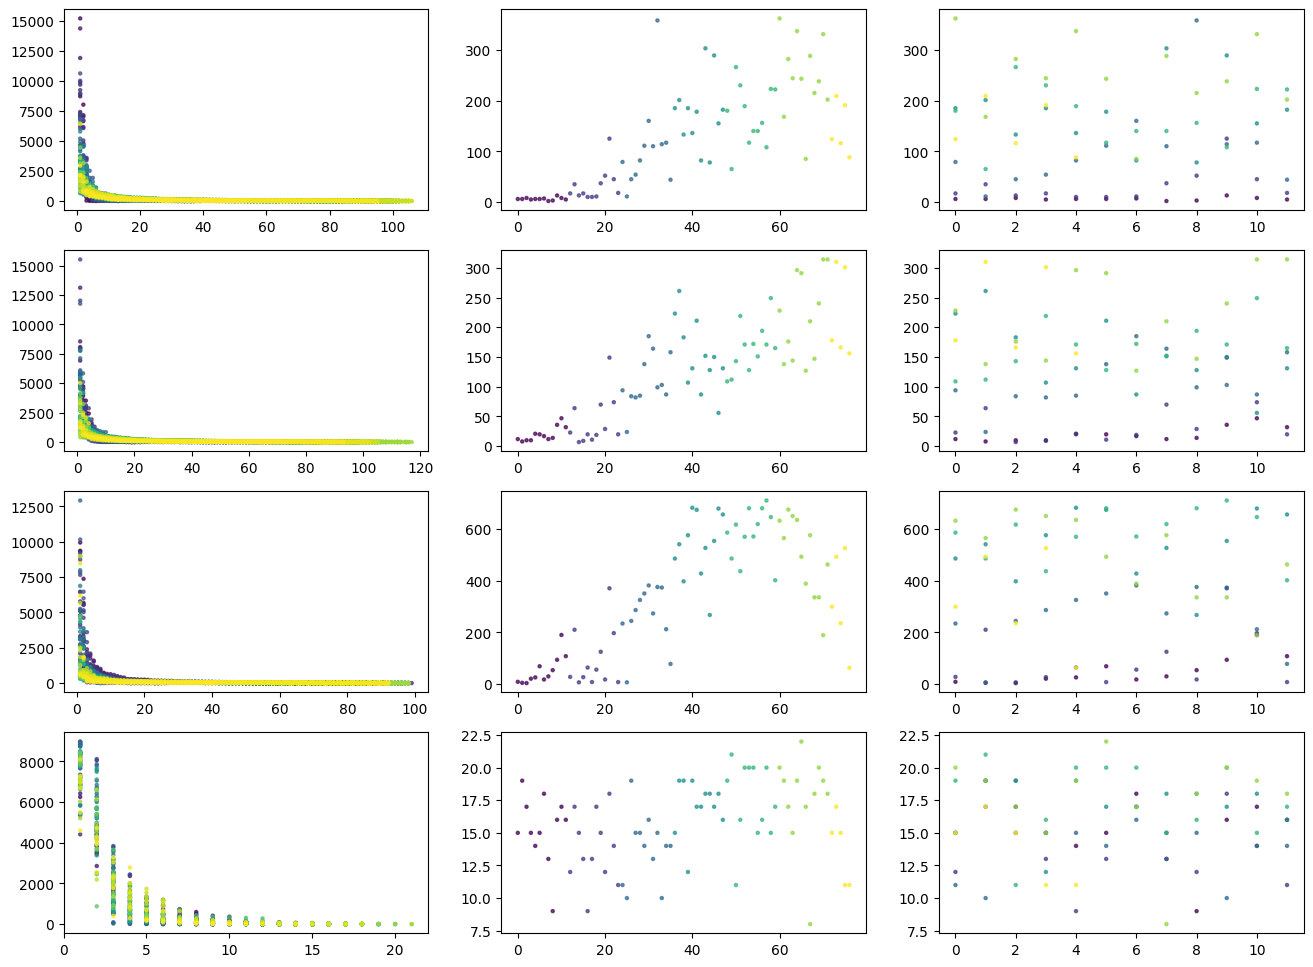

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(16, 12))
plot_token_frequencies(model, q_token_counts, ax=axs[0][0])
plot_unique_tokens_by_head(model, q_token_counts, ax=axs[0][1])
plot_unique_tokens_by_layer_head(model, q_token_counts, ax=axs[0][2])
plot_token_frequencies(model, k_token_counts, ax=axs[1][0])
plot_unique_tokens_by_head(model, k_token_counts, ax=axs[1][1])
plot_unique_tokens_by_layer_head(model, k_token_counts, ax=axs[1][2])
plot_token_frequencies(model, v_token_counts, ax=axs[2][0])
plot_unique_tokens_by_head(model, v_token_counts, ax=axs[2][1])
plot_unique_tokens_by_layer_head(model, v_token_counts, ax=axs[2][2])
plot_token_frequencies(model, token_counts, ax=axs[3][0])
plot_unique_tokens_by_head(model, token_counts, ax=axs[3][1])
plot_unique_tokens_by_layer_head(model, token_counts, ax=axs[3][2])
figure(
    fig,
    title="Token frequencies",
    footer="IMDB dataset",
)

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plot_token_embeddings(model, token_counts, 'TSNE', ax=axs[0][0])
plot_token_embeddings(model, q_token_counts, 'TSNE', ax=axs[0][1])
plot_token_embeddings(model, k_token_counts, 'TSNE', ax=axs[1][0])
plot_token_embeddings(model, v_token_counts, 'TSNE', ax=axs[1][1])

figure(
    fig,
    title="t-SNE for attention token embeddings",
    description="""
    t-SNE representation of the embeddings of the element-wise, query, key, and value attention tokens from top clockwise.
    Colours represent the layer index.
    """,
    footer="IMDB dataset",
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 128 (\x80) missing from current font.

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 134 (\x86) missing from current font.

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 140 (\x8c) missing from current font.

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 146 (\x92) missing from current font.

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 152 (\x98) missing from current font.

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning:

Glyph 158 (\x9e) missing from current font.

/Users/richardlayte/Work/layterz/experiments/v

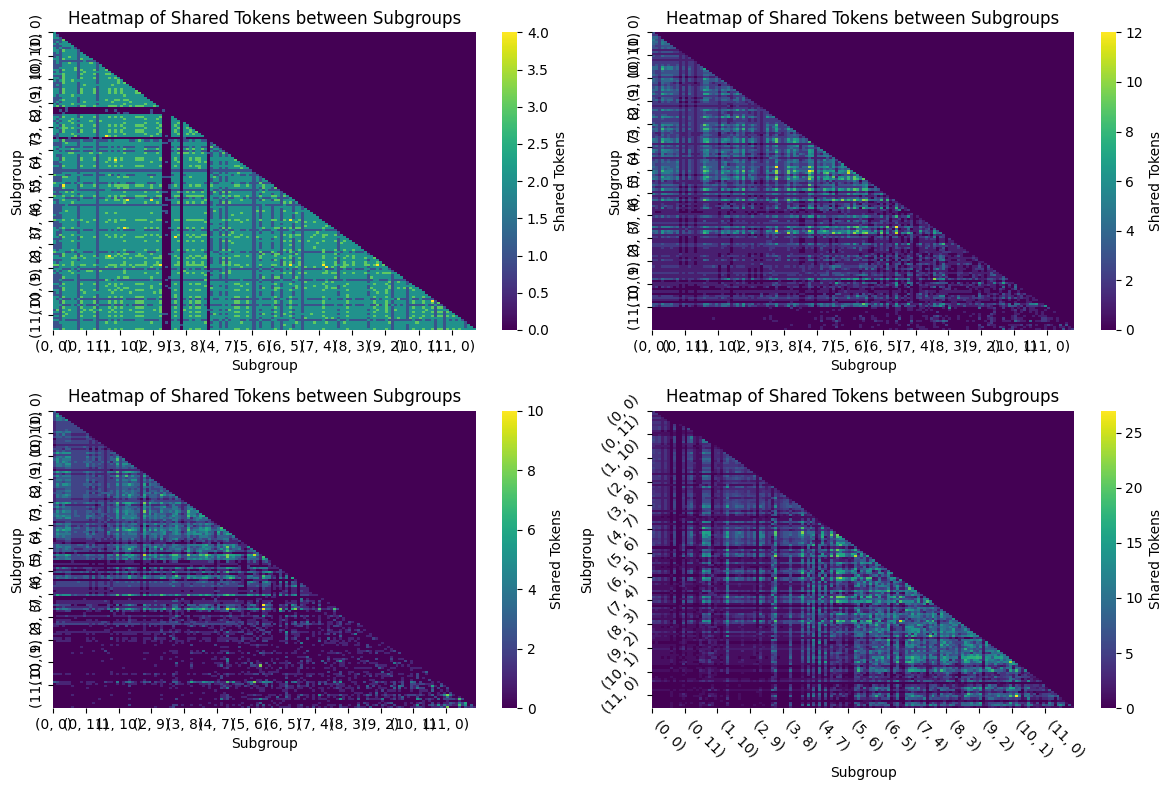

In [11]:
hp = shared_tokens(df)
q = shared_tokens(df, 'q')
k = shared_tokens(df, 'k')
v = shared_tokens(df, 'v')

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
visualize_shared_tokens(hp, ax=axs[0][0])
visualize_shared_tokens(q, ax=axs[0][1])
visualize_shared_tokens(k, ax=axs[1][0])
visualize_shared_tokens(v, ax=axs[1][1])

figure(
    fig,
    title="Shared tokens",
    description="""
    Heatmap of how tokens are shared between pairs of heads for element-wise, query, key, and value tokens from top clockwise.
    """,
    footer="IMDB dataset",
)

### Random inputs

Testing with random token inputs provides some insights into how the heads behave in a "default" state. It also makes it easy to change the input length without worrying about being distracted by how that affects the semantic/grammatical structure of the input.

Here are the heads of the first layer using a single random token repeated 62 times.

In [ ]:
token = random.randint(0, 50257)
prompt = torch.full((1, 31), token)
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(16, 12))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Random single token")

In [ ]:
prompt = torch.randint(0, 50257, (1, 31))
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(16, 12))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Random single token")

In [ ]:
prompt = torch.randint(0, 50257, (1, 3)).repeat(1, 10)
cache = run_prompts(model, *model.to_string(prompt))

plot, axs = plt.subplots(3, 4, figsize=(16, 12))
plt.subplots_adjust(wspace=0, hspace=0.5)
for i in range(12):
    attn_data = calculate_attns(cache, 0, i)
    plot_attn(cache, attn_data, ax=axs[i // 4, i % 4], hide_labels=True, title=f"Head {i}")

figure(plot, title="Random single token")

### Testing varying input lengths

Input length is important. Up to 31 tokens the attention tokens form surprisingly compact representations of the input across each position. At 32 input tokens some kind of criticality is reached, which dramatically increases the number of attention tokens defined for each input token. You can see this below where the final two lines account for the majority of assigned tokens. It's important to note this doesn't change the existing patterns above, but just makes it much more difficult to view them clearly using this visualization technique.

After 32 tokens, things get a bit weird. The attention token structure doesn't remain in the more complex high token count state - instead it appears to alternate between the simple and complex patterns. However, this somewhat depends on the selected random token so it's difficult to highlight a precise sequence.

Below is the same head (0.0) plotted using input from 31 up to 48 tokens. You can see the simple and complex pattern evolve twice in this range.

The same behaviour occurs with natural language input, but the threshold is less predictable. The point of criticality appears to align with the start of the most recent "block" of text. E.g. if it's a repeating sequence of length 4 the threshold is ~28. This isn't precise, but is relisably closer than 32 as seen with repeated and fully random inputs.

## Specific head analysis

Random repeating sequences provides the clearest interpretability without being devoid of structure so I'm starting there. Understanding how heads evolve based on changing predictable sequences is likely to provide more general insights, but it's worth noting again the risk of these toy inputs not translating to more realistic language.

To provide some structure to the work I plan to evaluate the patterns using this approach:
- Take an input sequence (S) and convert it into a sequence of attention tokens (A)
- Given the next token (t) generate a new sequence of attention tokens using S + t
- Analyse the invariances and symmetries implied by how different sequences produce different attention tokens

### 0.0